In [13]:
import numpy as np
import argparse
import imutils
from imutils import face_utils
import dlib
import cv2
import glob
import shutil
import os 
import matplotlib.pyplot as plt
shape_predictor = "shape_predictor_68_face_landmarks.dat" #dlib predictor
input_root = "" #input images root
input_txt_root = "" #input labels root
output_root = "" #output image root
output_txt_root = "" #output label root
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

In [15]:
#因為dlib吃固定width = 500
ratio = 192/50
pose = ['-10P','-20P','10P','20P','0P']
#自定義output size
fix_size = 512
for p in pose:
    uid_list = glob.glob(input_root+p+'/00*')
    for uid in uid_list:
        name = os.path.basename(uid)
        img_list = glob.glob(uid+'/*.png')
        box = list()
        #因為臉的位置固定，所以取整個平均來切臉，以避免有幾張圖片找不到而沒切到。
        for img in img_list:
            image = cv2.imread(img)
            resize_image = imutils.resize(image,width=500)
            gray = cv2.cvtColor(resize_image,cv2.COLOR_BGR2GRAY)
            rects = detector(gray, 1)
            temp = 0
            for r in rects:
                if r.width() > temp:
                    temp = r.width()
                    rect = r
            try:
                shape = predictor(gray, rect)
                shape = face_utils.shape_to_np(shape)
                x1 = int(min(shape[:,0])*ratio+0.5)
                y1 = int(min(shape[:,1])*ratio+0.5)
                x2 = int(max(shape[:,0])*ratio+0.5)
                y2 = int(max(shape[:,1])*ratio+0.5)
                xcen = (max(shape[:,0])+min(shape[:,0]))*0.5*ratio
                ycen = (max(shape[:,1])+min(shape[:,1]))*0.5*ratio
                width = max(max(shape[:,0])-min(shape[:,0]),max(shape[:,1])-min(shape[:,1]))*2/3*ratio
    #             plt.imshow(gray)
    #             plt.scatter(shape[:,0],shape[:,1],marker='.',s=50,c='r')
    #             plt.show()
                box.append([xcen,ycen,width])
        #         cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),50)
        #         plt.imshow(image)
        #         plt.savefig('D:/share/new_dataset/new_human_power_reorder/dirl_new_face/'+os.path.basename(img))
            except:
                continue
        box = np.array(box)
        mean_xcen = np.around(np.mean(box[:,0])).astype(np.int)
        mean_ycen = np.around(np.mean(box[:,1])).astype(np.int)
        mean_width = np.around(np.mean(box[:,2])).astype(np.int)
        output_ratio = fix_size/(mean_width*2)
        
        #將算出來的平均來切臉
        for img in img_list:
            filename = os.path.basename(img)[:-4]
            filepath = img[len(input_root):]
            if not os.path.exists(os.path.dirname(os.path.join(output_root,filepath))):
                os.makedirs(os.path.dirname(os.path.join(output_root,filepath)))
            if not os.path.exists(os.path.dirname(os.path.join(output_txt_root,filepath))):
                os.makedirs(os.path.dirname(os.path.join(output_txt_root,filepath)))
            txt = os.path.join(input_txt_root,filepath)[:-4]+'.txt'
            image = cv2.imread(img)
            if mean_ycen+mean_width > 1080:
                fix = mean_ycen+mean_width-1080
            else:
                fix = 0
            crop_image = image[mean_ycen-mean_width-fix:mean_ycen+mean_width-fix,mean_xcen-mean_width:mean_xcen+mean_width]
            crop_image = cv2.resize(crop_image,(fix_size,fix_size))
            txt = np.genfromtxt(txt,delimiter=',').astype(np.int)
            for t in txt:
                t[2] = int((t[2] - (mean_xcen-mean_width))*output_ratio+0.5)
                t[3] = int((t[3] - (mean_ycen-mean_width-fix))*output_ratio+0.5)
            
#             plt.imshow(crop_image)
#             plt.savefig('D:/share/new_dataset/new_human_power_reorder/dirl_new_face/crop_'+os.path.basename(img))
    
            cv2.imwrite(os.path.join(output_root,filepath),crop_image)
            
            #計算因為裁減框超出圖片邊界而平移裁減框的量
            with open(output_txt_root+'/bbox_list.txt','a+') as a:
                if fix == 0:
                    a.write(filepath+' 1 1 '+str(fix_size)+' '+str(fix_size)+'\n')                
                else:
                    a.write(filepath+' 1 '+str(int(fix*output_ratio+0.5)+1)+' '+str(fix_size)+' '+str(fix_size)+'\n') 
                    
            
#             plt.imshow(crop_image)
#             plt.scatter(txt[:,2],txt[:,3],s=50, marker='.', c='r')
#             plt.show()
#             break



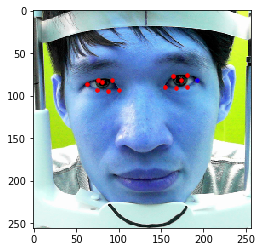

In [15]:
#測試是否切的正確
i = cv2.imread('')#a single image path
t = np.genfromtxt('',delimiter=',')#a single label path
# g = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
# g = np.expand_dims(g,2).repeat(3,axis=2)
plt.imshow(i)

plt.scatter(t[:,2],t[:,3],s=50,marker='.',c='r')
plt.scatter(t[7,2],t[7,3],s=50,marker='.',c='b')
plt.show()